In [8]:
#导入包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# 训练测试集分割
def train_test_split(X, y, train_size=None ,seed=None):
    """将数据 X 和 y 按照test_ratio分割成X_train, X_test, y_train, y_test"""
    assert X.shape[0] == y.shape[0], \
        "the size of X must be equal to the size of y"

    if seed:
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))

#     test_size = int(450)
    test_indexes = shuffled_indexes[train_size:]
    train_indexes = shuffled_indexes[:train_size]

    X_train = X[train_indexes]
    y_train = y[train_indexes]

    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

In [46]:
# 实现 LDA 算法

class LinearDiscrtAnays(object):
    def __init__(self):
        self.Xi_means = 0               #每个类别的均值向量
        self.Xbar = 0                   #整体的均值向量
        self.covMatrix = []             #每个类别的协方差矩阵
        self.covariance_ = 0            #整体的协方差矩阵
        self.X = 0                      #训练数据
        self.y = 0                      #训练数据的分类标签
        self.classes_ = 0               #具体类别
        self.priors_ = 0                #每个类别的先验概率
        self.n_samples = 0              #训练数据的样本数
        self.n_features = 0             #训练数据的特征数
        self.n_components = 0           #特征数
        self.w = 0                      #特征向量
    
    #初始化特征    
    """calculate params, including:
        0. X, y
        1. n_samples, n_features;
        2. classer, priors_;
        3. Xi_means, Xbar, covMatrix;
    
    """
    def _params_init(self, X, y):
        #0、赋值X和y
        self.X, self.y = X, y
        #1、计算样本数量和特征数量
        self.n_samples, self.n_features = X.shape
        #2、计算类别值、每个类别的先验概率
        self.classes_, yidx = np.unique(y, return_inverse=True)
        self.priors_ = np.bincount(y) / self.n_samples
        #3、计算每类的均值
        means = np.zeros((len(self.classes_), self.n_features))
        np.add.at(means, yidx, X)
        self.Xi_means = means / np.expand_dims(np.bincount(y), 1)
        #4、计算每类的协方差矩阵、整体的协方差矩阵
        self.covMatrix = [np.cov(X[y == group].T) \
                          for idx, group in enumerate(self.classes_)]
        self.covariance_ = sum(self.covMatrix) / len(self.covMatrix)
        #5、计算总体均值向量
        self.Xbar = np.dot(np.expand_dims(self.priors_, axis=0), self.Xi_means)
        return 
    
    #训练
    def train(self, X, y, n_components=None):
        #初始化一些参数
        self._params_init(X, y)
        #求类内平均散度
        Sw = self.covariance_
        #求类间平均散度
        Sb = sum([sum(y == group)*np.dot((self.Xi_means[idx,None] - self.Xbar).T, (self.Xi_means[idx,None] - self.Xbar)) \
                  for idx, group in enumerate(self.classes_)]) / (self.n_samples - 1)
        #SVD求Sw的逆矩阵
        U,S,V = np.linalg.svd(Sw)
        Sn = np.linalg.inv(np.diag(S))
        Swn = np.dot(np.dot(V.T,Sn),U.T)
        SwnSb = np.dot(Swn,Sb)
        #求特征值和特征向量，并取实数部分
        la,vectors = np.linalg.eig(SwnSb)
        la = np.real(la)
        vectors = np.real(vectors)
        #特征值的下标从大到小排列
        laIdx = np.argsort(-la)
        #默认选取(N-1)个特征值的下标
        if n_components == None:
            n_components = len(self.classes_)-1
        #选取特征值和向量
        lambda_index = laIdx[:n_components]
        w = vectors[:,lambda_index]
        self.w = w
        self.n_components = n_components
        return
    
    #求出投影后的矩阵
    def transform(self, X):
        return np.dot(X, self.w)
    
    #预测分类情况，出分类概率
    def predict_prob(self, X):
        #求整体协方差的逆
        Sigma = self.covariance_
        U,S,V = np.linalg.svd(Sigma)
        Sn = np.linalg.inv(np.diag(S))
        Sigman = np.dot(np.dot(V.T,Sn),U.T)
        #线性判别函数值
        value = np.log(np.expand_dims(self.priors_, axis=0)) - \
        0.5*np.multiply(np.dot(self.Xi_means, Sigman).T, self.Xi_means.T).sum(axis=0).reshape(1,-1) + \
        np.dot(np.dot(X, Sigman), self.Xi_means.T)
        return value/np.expand_dims(value.sum(axis=1),1)
    
    #预测分类情况，出具体分类值
    def predict(self, X):
        pValue = self.predict_prob(X)
        return np.argmax(pValue, axis=1)

In [47]:
#导入数据并给每一维属性命名
df = pd.read_csv("./blood_data.txt",sep=',',encoding='utf-8',header=None,)
df.columns = ['R','F','M','T','A']
print(df.head())
print(df.shape)

   R   F      M   T  A
0  2  50  12500  98  1
1  0  13   3250  28  1
2  1  16   4000  35  1
3  2  20   5000  45  1
4  1  24   6000  77  0
(748, 5)


In [54]:
cols=['R','F','M','T']
x = df[cols].values
y = df['A'].values
print(x.shape)
print(y.shape)

#8:2 训练:测试
x_train,x_test,y_train,y_test = train_test_split(x,y, train_size=int(748*0.8),seed=1)

# from LinearRegression import LinearRegression

print("训练数据集",x_train.shape,y_train.shape)
print("测试数据集",x_test.shape,y_test.shape)

(748, 4)
(748,)
训练数据集 (598, 4) (598,)
测试数据集 (150, 4) (150,)


In [55]:
lda= LinearDiscrtAnays()
lda.train(x_train,y_train)


In [65]:
#分类情况
pre_y = lda.predict(x_test)
print(pre_y)
print(y_test)
print("lda‘s accurancy is %.3f"%(sum(pre_y==y_test)/pre_y.shape[0]))

[0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0
 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 1]
[0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1
 0 1]
lda‘s accurancy is 0.620


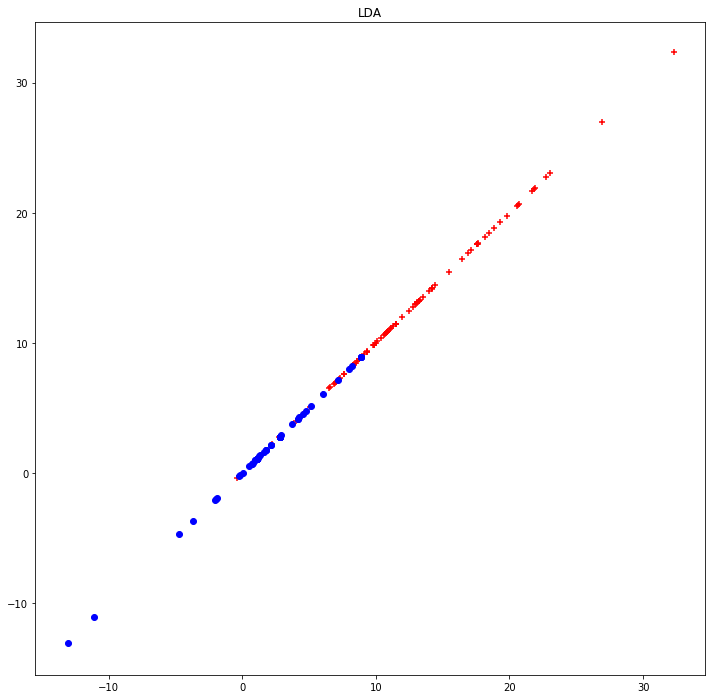

In [79]:
# 降维后的数据集画图
X_self = lda.transform(x_test)
# 自编码的LDA降维后数据
fig = plt.figure(figsize=(12,12)) 
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(X_self[pre_y==0],X_self[pre_y==0],c='r',marker='+')
ax1.scatter(X_self[pre_y==1],X_self[pre_y==1],c='b',marker='o')
ax1.set_title("LDA")
plt.show()

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_sklearn = LDA(solver="eigen", n_components=2)
lda_sklearn.fit(x_train, y_train)
pre_sklearn = lda_sklearn.predict(x_test)
print("lda_sklearn‘s accurancy is %.3f"%(sum(pre_sklearn==y_test)/pre_sklearn.shape[0]))

lda_sklearn‘s accurancy is 0.633


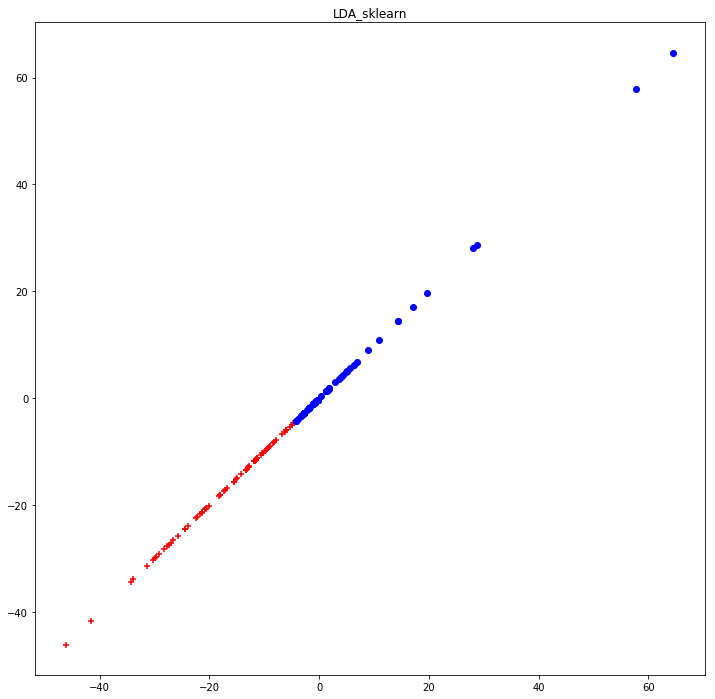

In [81]:
X_sklearn = lda_sklearn.transform(x_test)
fig = plt.figure(figsize=(12,12)) 
ax2 = fig.add_subplot(1,1,1)    
ax2.scatter(X_sklearn[pre_sklearn==0],X_sklearn[pre_sklearn==0],c='r',marker='+')
ax2.scatter(X_sklearn[pre_sklearn==1],X_sklearn[pre_sklearn==1],c='b',marker='o')
ax2.set_title("LDA_sklearn")
plt.show()